In [1]:
from google.colab import drive
from google.colab import files

#Read and write files directly from google drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [56]:
#install packages missing from the Colab environment
!pip install geopandas
!pip install rasterio

     |████████████████████████████████| 15.1MB 5.0MB/s 


In [0]:
#Import required packages
import geopandas as gpd
import rasterio
from shapely.geometry import mapping, Polygon
import matplotlib.pyplot as plt

In [0]:
#Read in the file of volcano polygons
volcanoes = gpd.read_file('drive/My Drive/Hamish mapping/Hamish mapping/Environmental layers/Shp/Island_volcanos_wgs.shp', 
                          driver='ESRI Shapefile')

,Name,geometry
0,Espanola,"POLYGON ((-89.69950 -1.34436, -89.69945 -1.344..."
1,Floreana,"POLYGON ((-90.42574 -1.22018, -90.42563 -1.220..."
2,Santa Fe,"POLYGON ((-90.08709 -0.79870, -90.08690 -0.798..."
3,San Cristobal,"POLYGON ((-89.35033 -0.68657, -89.35023 -0.686..."
4,Pinzon,"POLYGON ((-90.67279 -0.58736, -90.67264 -0.587..."


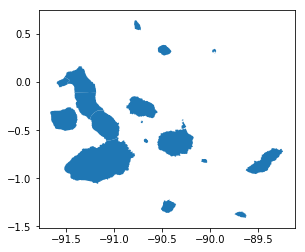

In [11]:
#Inspect the data
volcanoes.plot()
volcanoes.head()

In [112]:
#List each unique name in the volcanoes dataset
volcano_names = list(volcanoes.Name.unique())
volcano_names

['Espanola',
 'Floreana',
 'Santa Fe',
 'San Cristobal',
 'Pinzon',
 'Santa Cruz',
 'Baltra',
 'Rabida',
 'Seymour',
 'Fernandina',
 'Santiago',
 'Genovesa',
 'Marchena',
 'Pinta',
 'Alcedo',
 'Darwin',
 'Ecuador',
 'South',
 'Wolf']

In [0]:
#Create a dictionary to store (island : bounding_box) pairs
bbox = {}

#Store one bounding box for the entire archipelago
#Note: this is an array, not a Polygon
bbox['Archipelago'] = volcanoes.total_bounds

#Store one bounding box for each volcano
for island in volcano_names:
  bbox[island] = volcanoes[volcanoes['Name']==island].envelope

In [0]:
#Define functions for extracting a matplotlib compatible xlim and ylim from the bounding box
def x_lim_island(bboxes, island):
  
  zoom_factor = 0.15
  
  if island == 'Archipelago':
    xmin = bbox[island][0]
    xmax = bbox[island][2]
    
    zoom = (xmax - xmin) * zoom_factor
    
    return(xmin - zoom, xmax + zoom)
  
  else:
    xmin = mapping(bboxes[island])['bbox'][0]
    xmax = mapping(bboxes[island])['bbox'][2]
  
    zoom = (xmax - xmin) * zoom_factor
  
    return(xmin - zoom, xmax + zoom)

def y_lim_island(bboxes, island):
  
  zoom_factor = 0.15
  
  if island == 'Archipelago':
    ymin = bbox[island][1]
    ymax = bbox[island][3]
    
    zoom = (ymax - ymin) * zoom_factor
    
    return(ymin - zoom, ymax + zoom)
  
  else:
    ymin = mapping(bboxes[island])['bbox'][1]
    ymax = mapping(bboxes[island])['bbox'][3]
  
    zoom = (ymax - ymin) * zoom_factor
  
    return(ymin - zoom, ymax + zoom)

In [0]:
#Test on an environmental dataset
a_dem = rasterio.open('drive/My Drive/Hamish mapping/Hamish mapping/Environmental layers/DEM/Elevation.tif')

(-0.1462733039197957, 0.20754347120427213)

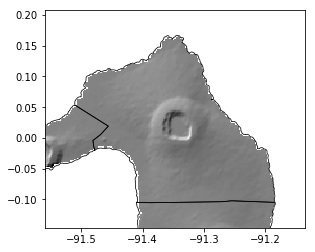

In [152]:
#Name of the island to plot
island_to_plot = 'Wolf'

ax = volcanoes.boundary.plot(color='k', linewidth=0.75)

plt.imshow(hillshade.read(1), 
          extent=(hillshade.bounds[0], hillshade.bounds[2], hillshade.bounds[1], hillshade.bounds[3]),
          cmap='gray')

plt.xlim(x_lim_island(bbox, island_to_plot))

plt.ylim(y_lim_island(bbox, island_to_plot))

In [0]:
#Define a Bounding Boxes class to store all calculations and methods for plotting
class Bounding_Boxes:

  #Instantiate Bounding_Boxes class using vector data - this class is written specifically to accept volcano specific data
  def __init__(self, vector_data):
    
    #Add vector_data attribute to inspect original vector data
    self.vector_data = vector_data
  
    #Add volcano_names class to inspect all unique volcano names (useful for plotting)
    volcano_names = list(vector_data.Name.unique())
    self.volcano_names = volcano_names
    
    #Add bboxes attribute to store bounding boxes around each volcano
    bbox = {}
    #Create one bounding box for the entire archipelago
    bbox['Archipelago'] = vector_data.total_bounds
    #Create bounding box for each island
    for island in volcano_names:
      bbox[island] = vector_data[vector_data['Name']==island].envelope
    self.bboxes = bbox
  
  #Define a method to create matplotlib compatible xlim
  def x_lim_island(self, island, zoom_factor=0.15):
    
    #Define the factor by which to zoom out x axis (this could be made into two zooms L & R)
    #z_factor = 0.15 means that 15% of the total boundign box will be added to both sides
    #This scales with the size of the island to add a border to all plots
    z_factor = zoom_factor
    
    #Archipelago is a ndarray data type not a Shapely Polygon
    if island == 'Archipelago':
      xmin = self.bboxes[island][0]
      xmax = self.bboxes[island][2]
    
      zoom = (xmax - xmin) * z_factor
      
      #Returns xlim ready for the plt.xlim function
      return(xmin - zoom, xmax + zoom)
    
    #Extract coordinates from Shapely Polygon bounding boxes
    else:
      xmin = mapping(self.bboxes[island])['bbox'][0]
      xmax = mapping(self.bboxes[island])['bbox'][2]
  
      zoom = (xmax - xmin) * z_factor
    
      #Returns xlim ready for the plt.xlim function    
      return(xmin - zoom, xmax + zoom)

  #Copy of x_lim_island for the y axis
  def y_lim_island(self, island, zoom_factor=0.15):
  
    z_factor = zoom_factor
  
    if island == 'Archipelago':
      ymin = self.bboxes[island][1]
      ymax = self.bboxes[island][3]
    
      zoom = (ymax - ymin) * z_factor
      
      return(ymin - zoom, ymax + zoom)
  
    else:
      ymin = mapping(self.bboxes[island])['bbox'][1]
      ymax = mapping(self.bboxes[island])['bbox'][3]
    
      zoom = (ymax - ymin) * z_factor
  
      return(ymin - zoom, ymax + zoom) 

In [0]:
#Test with the new class
#Import hillshade data
a_dem = rasterio.open('drive/My Drive/Hamish mapping/Hamish mapping/Environmental layers/DEM/Elevation.tif')

#Create a Bounding_Boxes class with the volcano data
island_boxes = Bounding_Boxes(volcanoes)

In [194]:
#Use example:
#Inspect the unique names for different volcanoes:
island_boxes.volcano_names

['Espanola',
 'Floreana',
 'Santa Fe',
 'San Cristobal',
 'Pinzon',
 'Santa Cruz',
 'Baltra',
 'Rabida',
 'Seymour',
 'Fernandina',
 'Santiago',
 'Genovesa',
 'Marchena',
 'Pinta',
 'Alcedo',
 'Darwin',
 'Ecuador',
 'South',
 'Wolf']

(-1.4219919263262653, -1.3341775718973765)

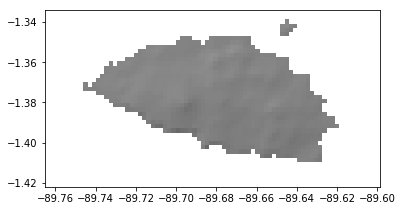

In [195]:
volcano_to_plot = 'Espanola'

plt.imshow(hillshade.read(1), 
          extent=(hillshade.bounds[0], hillshade.bounds[2], hillshade.bounds[1], hillshade.bounds[3]),
          cmap='gray')

plt.xlim(island_boxes.x_lim_island(volcano_to_plot))
plt.ylim(island_boxes.y_lim_island(volcano_to_plot))

(-0.5501591301497285, -0.34507396907832233)

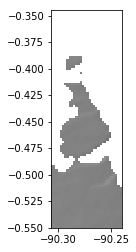

In [198]:
#Example with extreme y zoom out
volcano_to_plot = 'Baltra'

plt.imshow(hillshade.read(1), 
          extent=(hillshade.bounds[0], hillshade.bounds[2], hillshade.bounds[1], hillshade.bounds[3]),
          cmap='gray')

plt.xlim(island_boxes.x_lim_island(volcano_to_plot))
plt.ylim(island_boxes.y_lim_island(volcano_to_plot, 0.9))

(-0.4952256048627447, -0.40000749436530614)

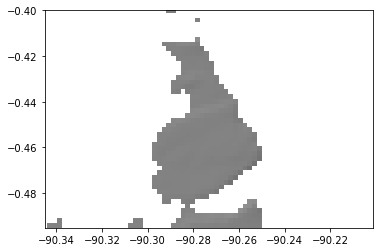

In [200]:
#Example with extreme x zoom out
volcano_to_plot = 'Baltra'

plt.imshow(hillshade.read(1), 
          extent=(hillshade.bounds[0], hillshade.bounds[2], hillshade.bounds[1], hillshade.bounds[3]),
          cmap='gray')

plt.xlim(island_boxes.x_lim_island(volcano_to_plot, 0.9))
plt.ylim(island_boxes.y_lim_island(volcano_to_plot))

In [0]:
#To add to this, store Bounding_Box class in a seperate file and import it here
#i.e. from bbox_class import Bounding_Box